## Citation ##
M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145

In [1]:
# Connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

# content in your drive is now available via "/content/drive/My Drive"


Mounted at /content/drive


In [2]:
# Import data and unzip files to folder
!unzip /content/drive/MyDrive/covid_radiography_data/COVID-19_Radiography_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7933.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7934.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7935.png  
 

In [3]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3


In [4]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

number of images for each category: [3616, 10192, 1345]
[['COVID-19_Radiography_Dataset/COVID/images/COVID-2579.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1097.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3339.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1157.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2970.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3183.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2800.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-696.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-997.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3148.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3165.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3585.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-103.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3342.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-140.png', 'COVID-19_Radiography_Dataset/COVID/images/COV

In [5]:
#Reduce number of images to first 1345 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [6]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img



#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [7]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [8]:
len(image_filepaths)

4032

In [9]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


4032
(4032, 192, 192, 3)
-0.0
1.0


In [10]:
len(fnames[2])

1344

In [11]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
4027,0,0,1
4028,0,0,1
4029,0,0,1
4030,0,0,1


### Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain ###

As COVID-19 started, it has been a serious issue that everyone has been pay attention on, the chest X-ray image is an efficient indicator that can determine the situation of this lung disease. The dataset has contain data of images that indicate 3 situations: COVID, NORMAL, and PNEUMONIA. By using models like transfer learning model and neural network, the predictive accuracy could be improved. Therefore, not only scientists or doctors can benefit from it for this research, the entire society can also benefit from it for knowing the disease better and having better treatment. 


###Visualize images that demonstrate when x-rays demonstrate Covid Positivity and when they do not (You can present visuals of each category in the data if you would like to.).



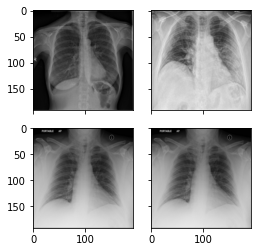

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor(fnames[0][0])
im2 =preprocessor(fnames[0][1])
im3 =preprocessor(fnames[1][1])
im4 =preprocessor(fnames[1][1])

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

In [13]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [14]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [15]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

#Save data
import pickle

# Open a file and use dump()
with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

#Save data
import pickle

# Open a file and use dump()
with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)


# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

In [16]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_test.pkl', 'rb') as file:
    # Call load method to deserialze
    y_test = pickle.load(file)

##Run at least three prediction models to try to predict x-ray images well.

### Model 1: Transfer Learning Model :VGG16

In [ ]:
# Create the base model from the pre-trained model VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

base_model = VGG16(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                              

In [ ]:
# Next step: Freeze the weights of the VGG16 model so that they are not trained when you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [ ]:
# Getting output tensor of the last VGG layer that we want to include
# base_model.layers[-1].output sets input for next model layer

# example of tending the vgg16 model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)

# define new model
model = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model

# summarize
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [ ]:
# Fit VGG16 model with frozen imagent weights and new input/output layer shapes (outputs have trainable parameters)
import tensorflow as tf
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  model.fit(X_train, y_train,batch_size=1,
          epochs = 10, verbose=1,validation_split=.2,callbacks=[mc,red_lr])

Epoch 1/10
2189/2192 [============================>.] - ETA: 0s - loss: 1.1479 - acc: 0.3545
Epoch 00001: val_acc improved from -inf to 0.40801, saving model to best_model.h5
2192/2192 [==============================] - 40s 13ms/step - loss: 1.1479 - acc: 0.3540 - val_loss: 1.0852 - val_acc: 0.4080 - lr: 0.0100
Epoch 2/10
2188/2192 [============================>.] - ETA: 0s - loss: 1.0945 - acc: 0.3629
Epoch 00002: val_acc did not improve from 0.40801
2192/2192 [==============================] - 28s 13ms/step - loss: 1.0945 - acc: 0.3631 - val_loss: 1.1059 - val_acc: 0.3406 - lr: 0.0100
Epoch 3/10
2191/2192 [============================>.] - ETA: 0s - loss: 1.1011 - acc: 0.3446
Epoch 00003: val_acc did not improve from 0.40801

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
2192/2192 [==============================] - 27s 13ms/step - loss: 1.1011 - acc: 0.3444 - val_loss: 1.0949 - val_acc: 0.3479 - lr: 0.0100
Epoch 4/10
2189/2192 [=======================

In [ ]:
import numpy as np
#Extract learning rate callback
learning_rates=model.history.history['lr'] # learning rates at each epoch

best_model_epoch=np.argmax(model.history.history['val_acc'])+1 # epoch of best model

print(learning_rates)
print(best_model_epoch)

[0.01, 0.01, 0.01, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005]
10


In [ ]:
model.save("model1.h5", save_format="h5")

### Model 2: CNN Model

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=16, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 5 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 10, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Epoch 1/10
69/69 [==============================] - 8s 49ms/step - loss: 0.7793 - accuracy: 0.6145 - val_loss: 0.6068 - val_accuracy: 0.7523
Epoch 2/10
69/69 [==============================] - 3s 39ms/step - loss: 0.5376 - accuracy: 0.7792 - val_loss: 0.4620 - val_accuracy: 0.7960
Epoch 3/10
69/69 [==============================] - 3s 39ms/step - loss: 0.4172 - accuracy: 0.8353 - val_loss: 0.4135 - val_accuracy: 0.8160
Epoch 4/10
69/69 [==============================] - 3s 42ms/step - loss: 0.3234 - accuracy: 0.8723 - val_loss: 0.3069 - val_accuracy: 0.8743
Epoch 5/10
69/69 [==============================] - 3s 41ms/step - loss: 0.2792 - accuracy: 0.8910 - val_loss: 0.3134 - val_accuracy: 0.8816
Epoch 6/10
69/69 [==============================] - 3s 40ms/step - loss: 0.2121 - accuracy: 0.9211 - val_loss: 0.3197 - val_accuracy: 0.8761
Epoch 7/10
69/69 [==============================] - 3s 41ms/step - loss: 0.1846 - accuracy: 0.9311 - val_loss: 0.2717 - val_accuracy: 0.9126
Epoch 8/10
69

In [ ]:
model.save("model2.h5", save_format="h5")

### Model 3: Neural *Network*

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.callbacks import ModelCheckpoint


with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
      opt=SGD(learning_rate=.001)

      model = Sequential()
      model.add(Dense(64,  input_shape=(192, 192, 3), activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Flatten())
      model.add(Dense(3, activation='softmax')) 

  
      mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
      red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs                                                
      # Compile model
      model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      # Fitting the NN to the Training set
      model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_data=(X_test,y_test),callbacks=[mc,red_lr])

Epoch 1/5
86/86 [==============================] - ETA: 0s - loss: 0.8363 - accuracy: 0.6355
Epoch 00001: val_accuracy improved from -inf to 0.69171, saving model to best_model.h5
86/86 [==============================] - 17s 189ms/step - loss: 0.8363 - accuracy: 0.6355 - val_loss: 0.6866 - val_accuracy: 0.6917 - lr: 0.0010
Epoch 2/5
86/86 [==============================] - ETA: 0s - loss: 0.6478 - accuracy: 0.7198
Epoch 00002: val_accuracy improved from 0.69171 to 0.71418, saving model to best_model.h5
86/86 [==============================] - 18s 205ms/step - loss: 0.6478 - accuracy: 0.7198 - val_loss: 0.6628 - val_accuracy: 0.7142 - lr: 0.0010
Epoch 3/5
86/86 [==============================] - ETA: 0s - loss: 0.6015 - accuracy: 0.7351
Epoch 00003: val_accuracy improved from 0.71418 to 0.74516, saving model to best_model.h5
86/86 [==============================] - 15s 173ms/step - loss: 0.6015 - accuracy: 0.7351 - val_loss: 0.5770 - val_accuracy: 0.7452 - lr: 0.0010
Epoch 4/5
86/86 [==

In [ ]:
model.save("model3.h5", save_format="h5")

### Submit Models

In [ ]:
# Begin to submit models to image classification leaderboard
! pip install aimodelshare --upgrade
# Restart session Runtime > Restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 967.8/967.8 KB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 KB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.3/96.3 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 KB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.3/44

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model1.h5',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7feb71da58b0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 13s 129ms/step


In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 357

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
# Reload model and data
import tensorflow as tf
model2 = tf.keras.models.load_model('model2.h5',compile=False)
model2.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 192, 192, 16)      448       
                                                                 
 conv2d_71 (Conv2D)          (None, 192, 192, 16)      272       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 96, 96, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 96, 96, 32)        4640      
                                                                 
 conv2d_73 (Conv2D)          (None, 96, 96, 32)        1056      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                 

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model2 = model_to_onnx(model2, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model2.onnx", "wb") as f:
    f.write(onnx_model2.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7feb71a65790>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model2.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 2s 24ms/step


In [ ]:
# Submit Model 2 to Competition Leaderboard
experiment.submit_model(model_filepath = "model2.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): cnn
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 358

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
# Reload model and data
import tensorflow as tf
model3 = tf.keras.models.load_model('model3.h5',compile=False)
model3.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 192, 192, 64)      256       
                                                                 
 dense_13 (Dense)            (None, 192, 192, 64)      4160      
                                                                 
 dense_14 (Dense)            (None, 192, 192, 64)      4160      
                                                                 
 dense_15 (Dense)            (None, 192, 192, 64)      4160      
                                                                 
 flatten_3 (Flatten)         (None, 2359296)           0         
                                                                 
 dense_16 (Dense)            (None, 3)                 7077891   
                                                                 
Total params: 7,090,627
Trainable params: 7,090,627
No

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model3 = model_to_onnx(model3, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model3.onnx", "wb") as f:
    f.write(onnx_model3.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7fead7ddfa60>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model3.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 3s 69ms/step


In [ ]:
# Submit Model 3 to Competition Leaderboard
experiment.submit_model(model_filepath = "model3.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): nn
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 359

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


Among these three models, the model is the CNN model that has the best prediction accuracy of 0.92 and it has 10 convolutional layers (filters:16,16,32,32,64,64,128,128,128,128) with maxpooling (pooling sizee=2).



## After discuss with team

In [ ]:
# Neural Network Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.callbacks import ModelCheckpoint


with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
      opt=SGD(learning_rate=.001)

      model = Sequential()
      model.add(Dense(128,  input_shape=(192, 192, 3), activation='relu'))
      model.add(Dense(256, activation='relu'))
      model.add(Dense(256, activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Flatten())
      model.add(Dense(3, activation='softmax')) 

  
      mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
      red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs                                                
      # Compile model
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

      # Fitting the NN to the Training set
      model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_data=(X_test,y_test),callbacks=[mc,red_lr])

Epoch 1/5
86/86 [==============================] - ETA: 0s - loss: 1.2762 - accuracy: 0.6976
Epoch 00001: val_accuracy improved from -inf to 0.77149, saving model to best_model.h5
86/86 [==============================] - 59s 610ms/step - loss: 1.2762 - accuracy: 0.6976 - val_loss: 0.4845 - val_accuracy: 0.7715 - lr: 0.0010
Epoch 2/5
86/86 [==============================] - ETA: 0s - loss: 0.4843 - accuracy: 0.7785
Epoch 00002: val_accuracy improved from 0.77149 to 0.77924, saving model to best_model.h5
86/86 [==============================] - 52s 603ms/step - loss: 0.4843 - accuracy: 0.7785 - val_loss: 0.5187 - val_accuracy: 0.7792 - lr: 0.0010
Epoch 3/5
86/86 [==============================] - ETA: 0s - loss: 0.4148 - accuracy: 0.8252
Epoch 00003: val_accuracy improved from 0.77924 to 0.82029, saving model to best_model.h5
86/86 [==============================] - 51s 598ms/step - loss: 0.4148 - accuracy: 0.8252 - val_loss: 0.4087 - val_accuracy: 0.8203 - lr: 0.0010
Epoch 4/5
86/86 [==

In [18]:
# CNN
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model_t2 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=16, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=256, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=256, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 5 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model_t2.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model_t2.fit(X_train, y_train, 
                    epochs = 10, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Epoch 1/10
69/69 [==============================] - 170s 2s/step - loss: 0.7611 - accuracy: 0.6341 - val_loss: 0.5831 - val_accuracy: 0.7432
Epoch 2/10
69/69 [==============================] - 166s 2s/step - loss: 0.5396 - accuracy: 0.7619 - val_loss: 0.4431 - val_accuracy: 0.8087
Epoch 3/10
69/69 [==============================] - 166s 2s/step - loss: 0.4129 - accuracy: 0.8321 - val_loss: 0.3734 - val_accuracy: 0.8361
Epoch 4/10
69/69 [==============================] - 190s 3s/step - loss: 0.3616 - accuracy: 0.8517 - val_loss: 0.3941 - val_accuracy: 0.8306
Epoch 5/10
69/69 [==============================] - 167s 2s/step - loss: 0.3026 - accuracy: 0.8764 - val_loss: 0.3384 - val_accuracy: 0.8743
Epoch 6/10
69/69 [==============================] - 167s 2s/step - loss: 0.2355 - accuracy: 0.9074 - val_loss: 0.2978 - val_accuracy: 0.8816
Epoch 7/10
69/69 [==============================] - 171s 2s/step - loss: 0.2091 - accuracy: 0.9188 - val_loss: 0.3322 - val_accuracy: 0.8725
Epoch 8/10
69

In [19]:
model_t2.save("modelteam.h5", save_format="h5")

In [ ]:
# Begin to submit models to image classification leaderboard
! pip install aimodelshare --upgrade
# Restart session Runtime > Restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 967.8/967.8 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.3/442.3 KB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 KB 24.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.3/96.3 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/51

In [20]:
# Reload model and data
import tensorflow as tf
modelteam = tf.keras.models.load_model('modelteam.h5',compile=False)
modelteam.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
modelteam.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 16)      272       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 32)        1056      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                    

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_modelteam = model_to_onnx(modelteam, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("modelteam.onnx", "wb") as f:
    f.write(onnx_modelteam.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f5bc7912790>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

41/41 [==============================] - 1s 19ms/step


In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit Model Team to Competition Leaderboard
experiment.submit_model(model_filepath = "modelteam.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 366

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


After discuss with my team, I fitted two models and submit the one that has higher prediction accuracy which is the CNN model with 10 layers (filter: 16,16,32,32,64,64,128,128,256,256)

## Data Augmentation

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [22]:
# This time we will load images from the original list of filenames, but we will not preprocess
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img

filenamelist=fnames[0]+fnames[1]+fnames[2]
len(filenamelist)

4032

In [23]:
# Train test split file names and labels
from sklearn.model_selection import train_test_split

X_train_datagen,X_test_datagen,y_train_datagen,y_test_datagen=train_test_split(filenamelist,y_labels,test_size=0.40,random_state=42)

print(X_train_datagen[0:5])
y_train_datagen[0:5] 

['COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-109.png', 'COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1345.png', 'COVID-19_Radiography_Dataset/Normal/images/Normal-8070.png', 'COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-329.png', 'COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-409.png']


['PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA']

In [24]:
import pandas as pd
trainingdata=pd.DataFrame.from_dict({'X': X_train_datagen, 'y': y_train_datagen})
testdata=pd.DataFrame.from_dict({'X': X_test_datagen, 'y': y_test_datagen})

trainingdata.head()

,X,y
0,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,PNEUMONIA
1,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,PNEUMONIA
2,COVID-19_Radiography_Dataset/Normal/images/Nor...,NORMAL
3,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,PNEUMONIA
4,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,PNEUMONIA


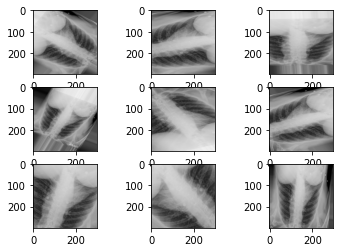

In [25]:
# example of image augmentation for single image
# see more options here: https://keras.io/preprocessing/image/
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img("COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png")
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(
        zoom_range=0.5,
        rotation_range=90,
        horizontal_flip=True,
        vertical_flip=True)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [26]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.5,

        horizontal_flip=True,
        vertical_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainingdata,
        directory=None,
        x_col="X", # Actual column names from data
        y_col="y",
        target_size=(192, 192),
        batch_size=1,
       shuffle=True)

Found 2419 validated image filenames belonging to 3 classes.


In [27]:
validation_generator = test_datagen.flow_from_dataframe(
        dataframe=testdata,
        directory=None,
        x_col="X",
        y_col="y",
        target_size=(192, 192),
        batch_size=1
        )


Found 1613 validated image filenames belonging to 3 classes.


In [29]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model_aug = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=16, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),Dropout(0.2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),Dropout(0.2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),Dropout(0.2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),Dropout(0.2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=256, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=256, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 5 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model_aug.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model_aug.fit(train_generator,
                    steps_per_epoch=len(trainingdata) / 1, epochs=2, #steps per epoch should be data samples/ image batch size but we have a small dataset, 
                                                                      #so we do not adjust our data into batches.
                    validation_data=validation_generator)

Epoch 1/2
2419/2419 [==============================] - 299s 123ms/step - loss: 1.0998 - accuracy: 0.3382 - val_loss: 1.0997 - val_accuracy: 0.3156
Epoch 2/2
2419/2419 [==============================] - 290s 120ms/step - loss: 1.0988 - accuracy: 0.3353 - val_loss: 1.0998 - val_accuracy: 0.3156


In [30]:
model_aug.save("model_aug.h5", save_format="h5")

Augmented data doesn't seem to increase accuracy but decreased a lot.

In [31]:
!pip install aimodelshare --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 967.8/967.8 KB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 KB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.3/442.3 KB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 KB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━

In [50]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model_aug.h5',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 192, 192, 16)      448       
                                                                 
 conv2d_21 (Conv2D)          (None, 192, 192, 16)      272       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 96, 96, 16)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 96, 96, 16)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 96, 96, 32)        4640      
                                                                 
 conv2d_23 (Conv2D)          (None, 96, 96, 32)        1056      
                                                      

In [51]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [52]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model_aug, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model_aug.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7fec201671f0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [53]:
apiurl='https://r4lkmt378i.execute-api.us-east-2.amazonaws.com/prod/m'
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit Model

#-- Generate predicted y values (Model 2)
prediction_column_index=model_aug.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model to Competition Leaderboard
experiment.submit_model(model_filepath = "model_aug.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

I have tried VGG 16, Neural Networks, CNN models with different parameters and augmented data. I found the best model is the CNN model with 10 conventional layers (filters: 16,16,32,32,64,64,128,128,128,128) with the accuracy of 0.92

GitHub Link: https://github.com/MoonLiang22/mlprojectsteps